In [10]:
import pandas as pd
import numpy as np
import random
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.environ import SolverFactory
import yfinance as yf
import matplotlib.pyplot as plt

## MODELO DE OTIMIZAÇÂO ROBUSTA COM DIVISAO EM SETORES


In [11]:
df_ativos=pd.read_csv(r'C:\Users\DECIV\Documents\GitHub\mestrado\base_dados\retornos_ativos2.csv').set_index(['Date'])
df_ibov=pd.read_csv(r'C:\Users\DECIV\Documents\GitHub\mestrado\base_dados\retorno_ibov2.csv').set_index(['Date']).dropna()

In [12]:
limite = np.int32(len(df_ativos) / 5 * 4)

retornos_ativo_treino = df_ativos[0:limite]
retornos_ativo_projecao = df_ativos[limite:]
retornos_ibov_treino = df_ibov[0:limite]
retornos_ibov_projecao = df_ibov[limite:]


In [13]:
retornos_ativo_treino.fillna(0, inplace=True)

C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\882124678.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retornos_ativo_treino.fillna(0, inplace=True)


In [14]:
dicio_ativos = {}
for t in range(len(retornos_ativo_treino)):
    for a in range(len(retornos_ativo_treino.columns)):
        dicio_ativos[t,a] = retornos_ativo_treino.iloc[t,a]

dicio_ibov = {}
for t in range(len(retornos_ibov_treino)):
    dicio_ibov[t] = retornos_ibov_treino['IBOV'].iloc[t]



In [15]:
std_ativos = retornos_ativo_treino.std()
std_ativos = pd.DataFrame(std_ativos, columns=['desvio_padrao'])
dicio_std = {}
for a in range(len(retornos_ativo_treino.columns)):
    dicio_std[a] = std_ativos['desvio_padrao'].iloc[a]


### SETORES

In [16]:
setores = {
'ITUB4.SA': 'Financeira','BBDC4.SA': 'Financeira', 'ITSA4.SA': 'Financeira','BPAC11.SA': 'Financeira','BBAS3.SA': 'Financeira','B3SA3.SA': 'Financeira','BBDC3.SA': 'Financeira','BBSE3.SA': 'Financeira',
'ALOS3.SA': 'Financeira','SANB11.SA': 'Financeira','MULT3.SA': 'Financeira','CXSE3.SA': 'Financeira','PSSA3.SA': 'Financeira','IGTI11.SA': 'Financeira','IRBR3.SA': 'Financeira',

'PETR4.SA': 'Petroleo_gas_biocombustiveis', 'PETR3.SA': 'Petroleo_gas_biocombustiveis','PRIO3.SA': 'Petroleo_gas_biocombustiveis','VBBR3.SA': 'Petroleo_gas_biocombustiveis','UGPA3.SA': 'Petroleo_gas_biocombustiveis',
'CSAN3.SA':'Petroleo_gas_biocombustiveis' ,'BRAV3.SA': 'Petroleo_gas_biocombustiveis','RECV3.SA': 'Petroleo_gas_biocombustiveis',
'RAIZ4.SA': 'Petroleo_gas_biocombustiveis',

'AXIA3.SA': 'Utilidade_publica','EQTL3.SA': 'Utilidade_publica','SBSP3.SA': 'Utilidade_publica','ENEV3.SA': 'Utilidade_publica','AXIA7.SA': 'Utilidade_publica','CPLE3.SA': 'Utilidade_publica','CMIG4.SA': 'Utilidade_publica',
'ENGI11.SA': 'Utilidade_publica','AXIA6.SA': 'Utilidade_publica','EGIE3.SA': 'Utilidade_publica','ISAE4.SA': 'Utilidade_publica','CSMG3.SA': 'Utilidade_publica','TAEE11.SA': 'Utilidade_publica',
'CPFE3.SA': 'Utilidade_publica','AURE3.SA': 'Utilidade_publica',

'WEGE3.SA': 'Bens_industriais','EMBJ3.SA': 'Bens_industriais','RAIL3.SA': 'Bens_industriais','MOTV3.SA': 'Bens_industriais','POMO4.SA': 'Bens_industriais','VAMO3.SA': 'Bens_industriais',

'ABEV3.SA': 'Consumo_nao_ciclico','MBRF3.SA': 'Consumo_nao_ciclico','ASAI3.SA': 'Consumo_nao_ciclico','NATU3.SA': 'Consumo_nao_ciclico','SLCE3.SA': 'Consumo_nao_ciclico','BEEF3.SA': 'Consumo_nao_ciclico',
'PCAR3.SA': 'Consumo_nao_ciclico',

'RENT3.SA': 'Consumo_ciclico','LREN3.SA': 'Consumo_ciclico','SMFT3.SA': 'Consumo_ciclico','CYRE3.SA': 'Consumo_ciclico','COGN3.SA': 'Consumo_ciclico','CURY3.SA': 'Consumo_ciclico',
'DIRR3.SA': 'Consumo_ciclico','MGLU3.SA': 'Consumo_ciclico','MRVE3.SA':'Consumo_ciclico' ,'VIVA3.SA': 'Consumo_ciclico','YDUQ3.SA': 'Consumo_ciclico','AZZA3.SA': 'Consumo_ciclico',
'CEAB3.SA': 'Consumo_ciclico','RENT4.SA': 'Consumo_ciclico','CYRE4.SA': 'Consumo_ciclico',

'RDOR3.SA': 'Saude','RADL3.SA': 'Saude','FLRY3.SA': 'Saude','HYPE3.SA': 'Saude','HAPV3.SA': 'Saude',

'SUZB3.SA': 'Materiais_basicos','GGBR4.SA': 'Materiais_basicos','KLBN11.SA': 'Materiais_basicos','CMIN3.SA': 'Materiais_basicos','GOAU4.SA': 'Materiais_basicos','CSNA3.SA': 'Materiais_basicos',
'BRAP4.SA': 'Materiais_basicos','USIM5.SA': 'Materiais_basicos','BRKM5.SA': 'Materiais_basicos','VALE3.SA':'Materiais_basicos',


'VIVT3.SA': 'Comunicacoes','TIMS3.SA': 'Comunicacoes',

'TOTS3.SA': 'Tecnologia',
    }

In [17]:
setores.items()

dict_items([('ITUB4.SA', 'Financeira'), ('BBDC4.SA', 'Financeira'), ('ITSA4.SA', 'Financeira'), ('BPAC11.SA', 'Financeira'), ('BBAS3.SA', 'Financeira'), ('B3SA3.SA', 'Financeira'), ('BBDC3.SA', 'Financeira'), ('BBSE3.SA', 'Financeira'), ('ALOS3.SA', 'Financeira'), ('SANB11.SA', 'Financeira'), ('MULT3.SA', 'Financeira'), ('CXSE3.SA', 'Financeira'), ('PSSA3.SA', 'Financeira'), ('IGTI11.SA', 'Financeira'), ('IRBR3.SA', 'Financeira'), ('PETR4.SA', 'Petroleo_gas_biocombustiveis'), ('PETR3.SA', 'Petroleo_gas_biocombustiveis'), ('PRIO3.SA', 'Petroleo_gas_biocombustiveis'), ('VBBR3.SA', 'Petroleo_gas_biocombustiveis'), ('UGPA3.SA', 'Petroleo_gas_biocombustiveis'), ('CSAN3.SA', 'Petroleo_gas_biocombustiveis'), ('BRAV3.SA', 'Petroleo_gas_biocombustiveis'), ('RECV3.SA', 'Petroleo_gas_biocombustiveis'), ('RAIZ4.SA', 'Petroleo_gas_biocombustiveis'), ('AXIA3.SA', 'Utilidade_publica'), ('EQTL3.SA', 'Utilidade_publica'), ('SBSP3.SA', 'Utilidade_publica'), ('ENEV3.SA', 'Utilidade_publica'), ('AXIA7.SA'

In [18]:
map_nome_ativo_para_indice = {nome: i for i, nome in enumerate(retornos_ativo_treino.columns)}
ativos_por_setor = {}
for ativo, setor in setores.items():
    if setor not in ativos_por_setor:
        ativos_por_setor[setor] = []
    # Adicionar o índice numérico do ativo
    if ativo in map_nome_ativo_para_indice:
         ativos_por_setor[setor].append(map_nome_ativo_para_indice[ativo])

In [19]:
# Obter a lista de nomes de setores únicos
lista_setores_unicos = list(ativos_por_setor.keys())

## INICIAR MODELO

In [20]:
model = pyo.ConcreteModel()

# RANGE SET
model.A = pyo.RangeSet(0,len(retornos_ativo_treino.columns)-1)
model.T = pyo.RangeSet(0, len(retornos_ativo_treino)-1)
# model.Sa = pyo.RangeSet(0,len(df_setores.columns)-1)
# model.St = pyo.RangeSet(0,len(df_setores)-1)
# PARAMETROS----------------------
model.ATIVOS = pyo.Param(model.T,model.A, initialize=dicio_ativos)
model.IBOV = pyo.Param(model.T, initialize=dicio_ibov)
model.DELTA = pyo.Param(model.A, initialize = dicio_std)
model.SETORES_IDX = pyo.Set(initialize=lista_setores_unicos)
model.MAX_ATIVOS_POR_SETOR = pyo.Param(initialize=4, mutable=True)
    ##----------------- GAMA: Orçamento de Incerteza -> Defini quantos ativos podem variar ao mesmo tempo (Seguro geral)
        ##  ------ mutable = True -> define parâmetros que podem ser alterados entre execuções de otimização sem reconstruir o modelo
            ##----model.GAMA = 2.0  # Forma simples  OU model.GAMA.store(2.0)
model.GAMA = pyo.Param(initialize = 5.0, mutable = True)
model.QUANTIDADE_ATIVOS = pyo.Param(initialize = 20.0)

# VARIAVEIS----------------------
model.x = pyo.Var(model.A, bounds=(0,1))
model.y = pyo.Var(model.A, within=pyo.Binary)
    ## Para cada dia $t$, o modelo precisa de variáveis extras para "absorver" a incerteza: z[t]: Uma variável global de proteção para o dia $t$. p[t, a]: Uma variável de proteção específica para cada ativo no dia $t$.
model.z = pyo.Var(model.T, bounds=(0,None))
model.p = pyo.Var(model.T, model.A, bounds=(0,None))
    #variavel do setor
# model.s = pyo.Var(model.A, within=pyo.Binary)

    #Capturar erro absoluto de cada dia
model.erro = pyo.Var(model.T, bounds=(0,None))

##------------ ALTERAÇÂO DE MSE para MAD 
def erro_pos(model, t):
    return model.erro[t] >= sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t]
def erro_neg(model, t):
    return model.erro[t] >= -(sum(model.ATIVOS[t,a] * model.x[a] for a in model.A) - model.IBOV[t])

model.con_erro_post = pyo.Constraint(model.T, rule=erro_pos)
model.con_erro_neg = pyo.Constraint(model.T, rule=erro_neg)
controle_peso_da_protecao = 0.1

# OBJETIVO----------------------
def func_objetivo_1(model):
    mad = sum(model.erro[t] for t in model.T)
    
    ## Termo de proteção Robusta -----------
    protecao = sum(
        (model.GAMA * model.z[t] + sum(model.p[t,a] for a in model.A)) for t in model.T
    )

    

    return mad + controle_peso_da_protecao*protecao

model.obj = pyo.Objective(rule=func_objetivo_1,sense=pyo.minimize)



In [21]:
# RESTRICOES ----------------------
    ## - Ela diz que a proteção deve ser maior ou igual ao impacto do desvio padrão no peso do ativo
def regra_protecao(model,t,a):
    
    return model.z[t] + model.p[t,a] >= model.DELTA[a] * model.x[a]

model.con_protecao = pyo.Constraint(model.T,model.A, rule=regra_protecao)

    ## OUTRAS RESTRIÇÔES

    # 1- Cardinalidade (total ativos na carteira)
def cardinalidade(model):

    return sum(
        model.y[a] for a in model.A
    ) <= model.QUANTIDADE_ATIVOS
model.cardinalidade = pyo.Constraint(rule=cardinalidade)

    # 2 - Soma peso da carteira
def soma_peso_1(model):
    return sum(model.x[a] for a in model.A) == 1
model.soma_peso_1 = pyo.Constraint(rule=soma_peso_1)

    # 3 - x só ativa se y=1
def restr_vinculo_x_y(model, a):

    return model.x[a] <= model.y[a]

model.restr_vinculo_x_y = pyo.Constraint(model.A, rule=restr_vinculo_x_y)

    # Retrição de Peso mínimo, se y=1, x deve ser pelo menos 1%
def peso_min(model, a):
    return model.x[a] >= 0.01 * model.y[a]
model.peso_min = pyo.Constraint(model.A, rule=peso_min)

    #Restrição de Setores
def regra_limite_setor(model, s):
    # 's' aqui é o nome de um setor (ex: 'Financeiro')
    # 'ativos_por_setor[s]' retorna a lista de ÍNDICES dos ativos daquele setor
    return sum(model.y[a] for a in ativos_por_setor[s]) <= model.MAX_ATIVOS_POR_SETOR
# A restrição é INDEXADA pelo conjunto de setores
model.con_limite_setor = pyo.Constraint(model.SETORES_IDX, rule=regra_limite_setor)

In [ ]:
# Antes do solve, dê uma solução inicial ao CPLEX
for a in model.A:
    model.x[a].value = 1/model.QUANTIDADE_ATIVOS  # Peso igual para 20 ativos
    model.y[a].value = 1 if a < model.QUANTIDADE_ATIVOS else 0

In [23]:
opt = SolverFactory('cplex', executable='C:\\CPLEX_Studio2211\\cplex\\bin\\x64_win64\\cplex.exe')
opt.options['TimeLimit'] = 480 
# resultado = opt.solve(model)
# opt.options['optimalitytarget'] = 3 ## PARA CASO DE MODELOS NAO LINEARES
opt.options['mip tolerances absmipgap'] = 0.01 
opt.options['mip tolerances mipgap'] = 0.01 
opt.options['mipgap'] = 0.01 

results = opt.solve(model, tee=True, warmstart=True)
print("-------FIM----------")



Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.1.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\DECIV\AppData\Local\Temp\tmpp6679eeq.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> New value for time limit in seconds: 480
CPLEX> New value for absolute mixed integer optimality gap tolerance: 0.01
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> Problem 'C:\Users\DECIV\AppData\Local\Temp\tmpavimh536.pyomo.lp' read.
Read time = 0.01 sec. (1.51 ticks)
CPLEX> MIP start file 'C:\Users\DECIV\AppData\Local\Temp\tmps90dcku2.cplex.mst' read.
CPLEX> Problem name         : C:\Users\DECIV\AppData\Local\Temp\tmpavimh536.pyomo.l

In [24]:
model.pprint()

1 Set Declarations
    SETORES_IDX : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {'Financeira', 'Petroleo_gas_biocombustiveis', 'Utilidade_publica', 'Bens_industriais', 'Consumo_nao_ciclico', 'Consumo_ciclico', 'Saude', 'Materiais_basicos', 'Comunicacoes', 'Tecnologia'}

2 RangeSet Declarations
    A : Dimen=1, Size=85, Bounds=(0, 84)
        Key  : Finite : Members
        None :   True :  [0:84]
    T : Dimen=1, Size=134, Bounds=(0, 133)
        Key  : Finite : Members
        None :   True : [0:133]

6 Param Declarations
    ATIVOS : Size=11390, Index=T*A, Domain=Any, Default=None, Mutable=False
        Key       : Value
           (0, 0) :    -0.0001977759331842
           (0, 1) :     0.0188730709784148
           (0, 2) :    -0.0196874689913214
           (0, 3) :     -0.020917037764773
           (0, 4) :      0.002491350836874
           (0, 5) :     0.0030321858694724
           (0, 6) :     0.0077

          peso_ativo  ativado
VALE3.SA    0.107821      1.0
PETR3.SA    0.067489      1.0
BBDC4.SA    0.068498      1.0
SBSP3.SA    0.055707      1.0
B3SA3.SA    0.050875      1.0
ITSA4.SA    0.133205      1.0
WEGE3.SA    0.020720      1.0
BBAS3.SA    0.047812      1.0
EMBJ3.SA    0.039877      1.0
ABEV3.SA    0.041813      1.0
PRIO3.SA    0.035252      1.0
VBBR3.SA    0.045561      1.0
VIVT3.SA    0.038928      1.0
CPLE3.SA    0.071403      1.0
TOTS3.SA    0.023298      1.0
RAIL3.SA    0.025921      1.0
AXIA6.SA    0.062007      1.0
DIRR3.SA    0.032276      1.0
USIM5.SA    0.019985      1.0
HAPV3.SA    0.011551      1.0
118.36323484168896
110.8979867113111
117.56706285563654


C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\3020107507.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_otimizado[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\3020107507.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_equi[-1])
C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\3020107507.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(acum_ibov[-1])


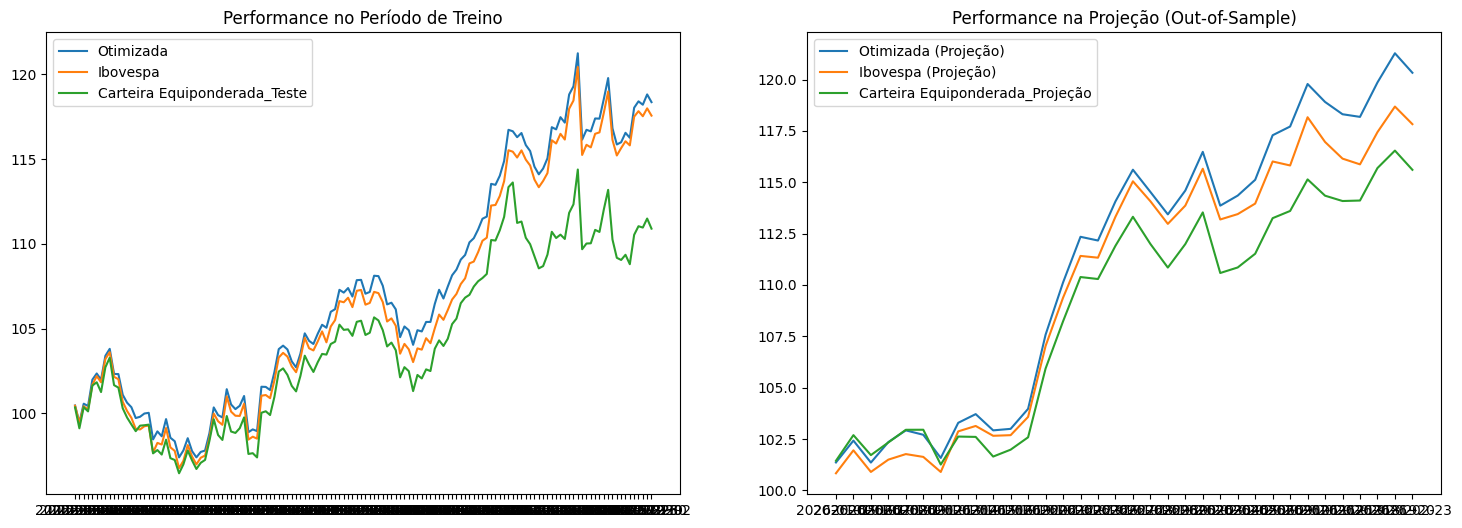

In [33]:
lsita_grande = []
for numero in range(len(retornos_ativo_treino.columns)):
    peso_ativo = pyo.value(model.x[numero])
    ativado = pyo.value(model.y[numero])
    
    lista = [peso_ativo, ativado]
    lsita_grande.append(lista)
    
final = pd.DataFrame(lsita_grande, columns=["peso_ativo","ativado"], index=retornos_ativo_treino.columns)
print(final[final['ativado']==1])
df_final = final[final['ativado']==1]
# df_final.head()
ativos_selecionados = df_final.index
retornos_carteira= retornos_ativo_treino[ativos_selecionados]
retornos_carteira_projecao= retornos_ativo_projecao[ativos_selecionados]


carteira_otimizada = (retornos_carteira*df_final['peso_ativo']).sum(axis=1)
carteira_otimizada = 1 + carteira_otimizada
#criar a carteira equiponderada, com pesos iguais

carteira_equi = retornos_carteira.mean(axis=1)
carteira_equi = 1 + carteira_equi
carteira_equi_projecao = retornos_carteira_projecao.mean(axis=1)
carteira_equi_projecao = 1 + carteira_equi_projecao


# 3. Transformar em Retorno Acumulado (Base 100)
acum_otimizado = (carteira_otimizada).cumprod() * 100
acum_equi = (carteira_equi).cumprod() * 100
acum_ibov = (1 + retornos_ibov_treino['IBOV']).cumprod() * 100

# Use os pesos que você já encontrou no modelo
carteira_projecao = (retornos_ativo_projecao[ativos_selecionados] * df_final["peso_ativo"]).sum(axis=1)
acum_projecao = (1 + carteira_projecao).cumprod() * 100
acum_equi_projecao = (carteira_equi_projecao).cumprod() * 100

print(acum_otimizado[-1])
print(acum_equi[-1])
print(acum_ibov[-1])

qnt_carteira = pyo.value(model.QUANTIDADE_ATIVOS)
texto = f'Comparação de Performance: Index Tracking ({qnt_carteira} ativos)'

plt.figure(figsize=(18, 6))


# Gráfico 1: Período de Treino
plt.subplot(1, 2, 1)
plt.plot(acum_otimizado, label="Otimizada")
plt.plot(acum_ibov, label="Ibovespa")
plt.plot(acum_equi, label="Carteira Equiponderada_Teste")
plt.title("Performance no Período de Treino")
plt.legend()

# Gráfico 2: Período de Projeção (Out-of-Sample)
plt.subplot(1, 2, 2)
plt.plot(acum_projecao, label="Otimizada (Projeção)")
plt.plot((1 + retornos_ibov_projecao["IBOV"]).cumprod() * 100, label="Ibovespa (Projeção)")
plt.plot(acum_equi_projecao, label="Carteira Equiponderada_Projeção")
plt.title("Performance na Projeção (Out-of-Sample)")
plt.legend()

plt.show()

In [39]:
map_nome_ativo_para_indice.items()

dict_items([('VALE3.SA', 0), ('ITUB4.SA', 1), ('PETR4.SA', 2), ('PETR3.SA', 3), ('AXIA3.SA', 4), ('BBDC4.SA', 5), ('SBSP3.SA', 6), ('B3SA3.SA', 7), ('ITSA4.SA', 8), ('BPAC11.SA', 9), ('WEGE3.SA', 10), ('BBAS3.SA', 11), ('EMBJ3.SA', 12), ('ABEV3.SA', 13), ('EQTL3.SA', 14), ('RENT3.SA', 15), ('RDOR3.SA', 16), ('ENEV3.SA', 17), ('PRIO3.SA', 18), ('VBBR3.SA', 19), ('SUZB3.SA', 20), ('RADL3.SA', 21), ('AXIA7.SA', 22), ('VIVT3.SA', 23), ('UGPA3.SA', 24), ('BBDC3.SA', 25), ('GGBR4.SA', 26), ('CPLE3.SA', 27), ('CMIG4.SA', 28), ('TIMS3.SA', 29), ('TOTS3.SA', 30), ('BBSE3.SA', 31), ('RAIL3.SA', 32), ('ENGI11.SA', 33), ('AXIA6.SA', 34), ('MOTV3.SA', 35), ('KLBN11.SA', 36), ('LREN3.SA', 37), ('ALOS3.SA', 38), ('MBRF3.SA', 39), ('SANB11.SA', 40), ('ASAI3.SA', 41), ('EGIE3.SA', 42), ('ISAE4.SA', 43), ('CSAN3.SA', 44), ('CSMG3.SA', 45), ('MULT3.SA', 46), ('CXSE3.SA', 47), ('SMFT3.SA', 48), ('TAEE11.SA', 49), ('PSSA3.SA', 50), ('CPFE3.SA', 51), ('CMIN3.SA', 52), ('BRAV3.SA', 53), ('CYRE3.SA', 54), ('G

In [40]:
# Exemplo de como verificar os dados criados:
print("Lista de Setores Únicos:")
print(lista_setores_unicos)
print("\nAtivos (índices) por Setor:")
for setor, ativos in ativos_por_setor.items():
    print(f"- {setor}: {ativos}")

Lista de Setores Únicos:
['Financeira', 'Petroleo_gas_biocombustiveis', 'Utilidade_publica', 'Bens_industriais', 'Consumo_nao_ciclico', 'Consumo_ciclico', 'Saude', 'Materiais_basicos', 'Comunicacoes', 'Tecnologia']

Ativos (índices) por Setor:
- Financeira: [1, 5, 8, 9, 11, 7, 25, 31, 38, 40, 46, 47, 50, 62, 65]
- Petroleo_gas_biocombustiveis: [2, 3, 18, 19, 24, 44, 53, 74, 84]
- Utilidade_publica: [4, 14, 6, 17, 22, 27, 28, 33, 34, 42, 43, 45, 49, 51, 70]
- Bens_industriais: [10, 12, 32, 35, 66, 81]
- Consumo_nao_ciclico: [13, 39, 41, 57, 71, 79, 83]
- Consumo_ciclico: [15, 37, 48, 54, 59, 60, 64, 67, 68, 69, 72, 73, 77, 80, 82]
- Saude: [16, 21, 56, 58, 76]
- Materiais_basicos: [20, 26, 36, 52, 55, 61, 63, 75, 78, 0]
- Comunicacoes: [23, 29]
- Tecnologia: [30]


In [41]:
#     <!-- #Restrição de Setores
# def regra_limite_setor(model, s):
#     # 's' aqui é o nome de um setor (ex: 'Financeiro')
#     # 'ativos_por_setor[s]' retorna a lista de ÍNDICES dos ativos daquele setor
#     return sum(model.y[a] for a in ativos_por_setor[s]) <= model.MAX_ATIVOS_POR_SETOR
# # A restrição é INDEXADA pelo conjunto de setores
# model.con_limite_setor = pyo.Constraint(model.SETORES_IDX, rule=regra_limite_setor) -->

In [42]:
df_final['codigo'] = range(20)
df_final['setor'] = range(20)
for i in range(len(df_final)):
    for ativo, codigo in map_nome_ativo_para_indice.items():
        if df_final.index[i] == ativo:
            df_final['codigo'].iloc[i] = codigo



C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\2576747276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['codigo'] = range(20)
C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\2576747276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['setor'] = range(20)
C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\2576747276.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain ca

In [43]:
# df_final['codigo'].iloc[1] 

for setor, codigo in ativos_por_setor.items():
    # print(setor, codigo)
    for i in range(len(df_final)):
        # print(df_final['codigo'].iloc[i])
        if df_final['codigo'].iloc[i] in codigo:
            # df_final['setor'].iloc[i] == setor
            # print('ESTA DENTRO', setor)
            # print(df_final['setor'].iloc[i])
            df_final['setor'].iloc[i] = setor
            

C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\3469030822.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_final['setor'].iloc[i] = setor
C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\3469030822.py:11: SettingWithCopyWarning: 
A 

In [44]:
df_final.drop(columns=['codigo'],inplace=True)

C:\Users\DECIV\AppData\Local\Temp\ipykernel_4532\2958652453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop(columns=['codigo'],inplace=True)


In [45]:
df_final.sort_values(['setor'])

,peso_ativo,ativado,setor
RAIL3.SA,0.025921,1.0,Bens_industriais
WEGE3.SA,0.020720,1.0,Bens_industriais
EMBJ3.SA,0.039877,1.0,Bens_industriais
VIVT3.SA,0.038928,1.0,Comunicacoes
DIRR3.SA,0.032276,1.0,Consumo_ciclico
ABEV3.SA,0.041813,1.0,Consumo_nao_ciclico
BBDC4.SA,0.068498,1.0,Financeira
B3SA3.SA,0.050875,1.0,Financeira
ITSA4.SA,0.133205,1.0,Financeira
BBAS3.SA,0.047812,1.0,Financeira


In [46]:
df_final.sort_values(['peso_ativo'], ascending=False)

,peso_ativo,ativado,setor
ITSA4.SA,0.133205,1.0,Financeira
VALE3.SA,0.107821,1.0,Materiais_basicos
CPLE3.SA,0.071403,1.0,Utilidade_publica
BBDC4.SA,0.068498,1.0,Financeira
PETR3.SA,0.067489,1.0,Petroleo_gas_biocombustiveis
AXIA6.SA,0.062007,1.0,Utilidade_publica
SBSP3.SA,0.055707,1.0,Utilidade_publica
B3SA3.SA,0.050875,1.0,Financeira
BBAS3.SA,0.047812,1.0,Financeira
VBBR3.SA,0.045561,1.0,Petroleo_gas_biocombustiveis
